# <center> <b> <font color='blue'> ELECTRICAL PRODUCTION </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Model selection](#5)
6. [Making predictions](#6)
7. [Annex](#annex)

<a name="1"></a>
## <font color='#2e86c1'> <b> 1. Problem Statement </font> </b>

We're gonna predict the electrical production. It is a time series problem.

<a name="2"></a>
## <font color='#2e86c1'> <b> 2. Setup </font> </b>

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import pandas as pd

In [8]:
logging.set_verbosity(logging.ERROR)

<a name="3"></a>
## <font color='#2e86c1'> <b> 3. Helper Functions </font> </b>

In [65]:
# plot time series
import matplotlib.pyplot as plt

def plot_series(time, series, title, xlabel, ylabel, format="-", start=0, end=None, color='blue'):
    plt.plot(time[start:end], series[start:end], format, color=color)

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])
    
    # Set title with bold and colored text
    plt.title(title, fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'darkred'})
    
    # Set xlabel with bold and colored text
    plt.xlabel(xlabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    # Set ylabel with bold and colored text
    plt.ylabel(ylabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    plt.grid(True)
    plt.show()  # Show the plot if desired

    

def plot_train_val(time_train, series_train, time_valid, series_valid):
    plt.figure(figsize=(12, 6))
    plt.plot(time_train, series_train, label='Training Set', color='blue')
    plt.plot(time_valid, series_valid, label='Validation Set', color='orange')

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])

    # Adding titles and labels
    plt.title('Training and Validation Sets')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.axvline(x=time_train[-1], color='red', linestyle='--', label='Split Point')  # Optional: Split line
    plt.legend()
    plt.grid()
    plt.show()
    


<a name="4"></a>
## <font color='#2e86c1'> <b> 4. Loading and pre-processing data </font> </b>

This project uses the [Electric Production](https://www.kaggle.com/datasets/shenba/electricity-production) dataset by Kaggle.

### Loading data

In [14]:
!cd data && ls

Electric_Production.csv


In [15]:
data = pd.read_csv('data/Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


### Exploration

In [16]:
data.shape

(397, 2)

In [18]:
data.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [56]:
data.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values.

In [19]:
times = data['DATE']
consumption = data['IPG2211A2N']

In [44]:
# Class for storing data
@dataclass
class G:
    #TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    #times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = times.values
    SERIES = consumption.values
    SPLIT_TIME = 250
    WINDOW_SIZE = 7
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8

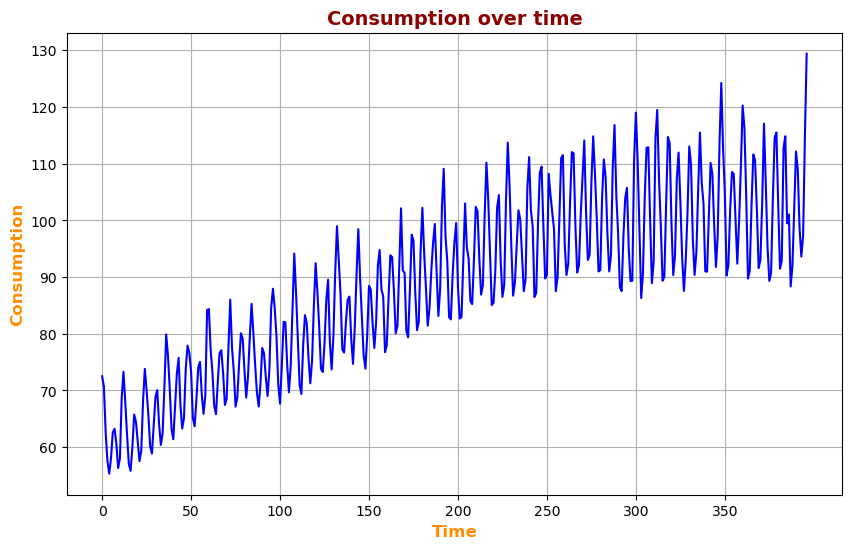

In [39]:
# plot time series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, 'Consumption over time', 'Time', 'Consumption')
plt.show()

We can see a growing trend.

### Train/Test split

In [45]:
# train/test split
def train_val_split(time, series, split_size):
    """
    Split the time series data into training and validation sets.
    We do not shuffle the data because is a time series problem.

    Parameters:
    - time (list-like): List or array containing the time index of the time series.
    - series (list-like): List or array containing the values of the time series.
    - split_size (float): The proportion of data to be allocated for training.
                          Value should be between 0 and 1.

    Returns:
    - time_train (list-like): Time index of the training set.
    - series_train (list-like): Values of the training set.
    - time_valid (list-like): Time index of the validation set.
    - series_valid (list-like): Values of the validation set.

    Example:
        If time = [1, 2, 3, 4, 5] and series = [10, 20, 30, 40, 50],
            and split_size = 0.8, then the function returns:
                time_train = [1, 2, 3]
                series_train = [10, 20, 30]
                time_valid = [4, 5]
                series_valid = [40, 50]
    """
    
    # índice de la divisón
    training_size = int(len(time)*split_size)

    time_train = time[:training_size]
    series_train = series[:training_size]
    time_valid = time[training_size:]
    series_valid = series[training_size:]

    return time_train, series_train, time_valid, series_valid

In [46]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_SIZE)

In [47]:
time_train.shape, series_train.shape, time_valid.shape, series_valid.shape

((317,), (317,), (80,), (80,))

Let's plot our sets.

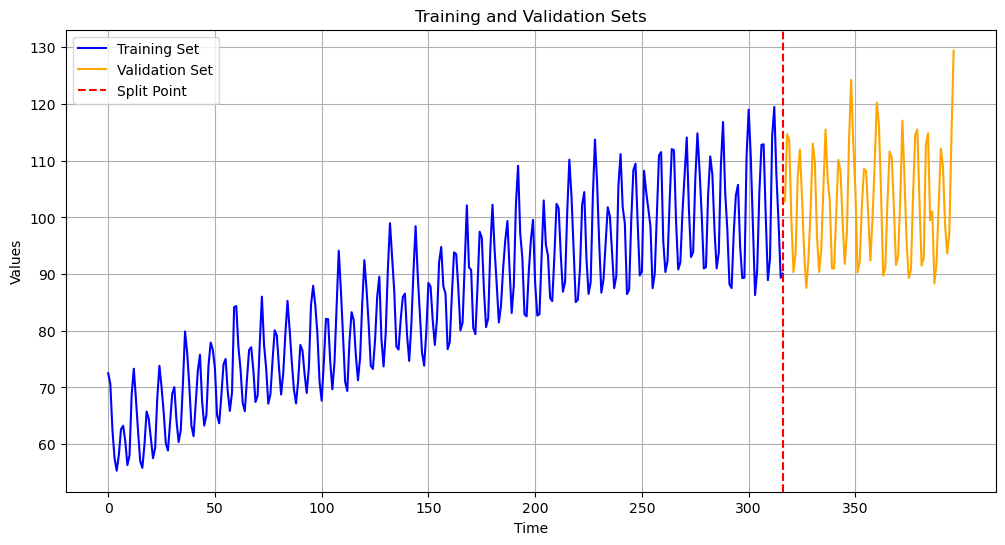

In [66]:
plot_train_val(time_train, series_train, time_valid, series_valid)

### Windowing the dataset

In [49]:
# windowing the dataset
def windowed_dataset(series, 
                     window_size, 
                     batch_size, 
                     shuffle_buffer=200,
                     shuffle=True):
    """
    Create a windowed dataset for time series prediction.

    Parameters:
    - series: 1D array-like structure containing the time series data.
    - window_size: Size of the window for features.
    - batch_size: Number of samples per batch.
    - shuffle_buffer: Size of the shuffle buffer.
    - shuffle: Boolean indicating whether to shuffle the dataset.

    Returns:
    - A TensorFlow dataset of input-output pairs.
    """
    if window_size <= 0 or batch_size <= 0:
        raise ValueError("window_size and batch_size must be greater than 0")
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # drop_remainder -> all of the same size
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    ds = ds.map(lambda w: (w[:-1], w[-1]))  # Input-output mapping; w[:-1] all but the last; w[-1]: the last
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds


In [50]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, 
                             batch_size=G.BATCH_SIZE)

In [52]:
# Apply to the validation set; NO shuffle
val_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, 
                           batch_size=G.BATCH_SIZE,shuffle=False)

<a name="5"></a>
## <font color='#2e86c1'> <b> 5. Model Selection </font> </b>

In [67]:
tf.random.set_seed(42)

results = {}

In [72]:
# naive forecast
naive_forecast = series_valid[:-1]

# Calcula el MAE entre la serie de validación y el naive forecast
mae = tf.keras.losses.mean_absolute_error(series_valid[1:], naive_forecast)

# show
mae.numpy()

8.27027594936709

In [68]:
def build_model_one():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0) #rescaling
    ]) 
    
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"]) 

    return model

In [69]:
model_one = build_model_one()
model_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 256)         133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 297601 (1.14 MB)
Trainable params: 297601 

In [70]:
# Fit the model
history_one = model_one.fit(
            train_set,
            epochs=20,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

In [71]:
scores_one = model_one.evaluate(val_set)

3/3 [==============================] - 0s 11ms/step - loss: 5.6141 - mae: 5.6141
